### Modelo Red Neuronal (keras)

###### Paso 0 - Instalación de dependencias e importaciones de librerías

In [ ]:
# Install dependencies here
#%pip install keras
#%pip install tensorflow

%pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Include your imports here

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import shap

#from keras.models import load_model
#from tensorflow.keras import Model
#from tensorflow.keras.layers import Dense, Flatten, Conv2D
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
# import seaborn as sns

# from sklearn.model_selection import GridSearchCV
#https://www.tensorflow.org/tutorials/quickstart/advanced

##### Paso 1 - Carga de datos y preprocesamiento

In [ ]:
# Importamos el modelo de keras datasets Minst para facilitar el acceso y la lectura de datos
mnist = tf.keras.datasets.mnist

#Descargamos los datos de la database y realizamos las transformaciones y las normalizaciones pertienentes.
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

# Incluimos una nueva dimension a nuestro dataset.
X_train = X_train[..., tf.newaxis].astype("float32")
X_test = X_test[..., tf.newaxis].astype("float32")

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test= tf.convert_to_tensor(X_test, dtype=tf.float32)


#y_train = keras.utils.to_categorical(y_train, 10)
#y_test = keras.utils.to_categorical(y_test, 10)


# Creamos la función que adapta los datos.
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

# Convertimos los datos al formato que posteriormente necesitaremos.
X_train = to_rgb(X_train)
X_test = to_rgb(X_test)

#Comprobamos que se ha incluido correctamente la nueva dimension a nuestro dataset.
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 3)
(10000, 28, 28, 3)


In [ ]:
#Se asemeja al Dataloader de Pytorch, transforamos a Tensor y realizamos los batches.
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

##### Paso 2 - Creación de la red neuronal

In [ ]:
#Creación de la estructura de la red neuronal (Keras)

model = Sequential()

model.add(Conv2D(32, 3, activation='relu', input_shape=(28,28,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

#Función de perdida
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#Optimizador
optimizer = tf.keras.optimizers.SGD()

#Compilamos
model.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])


In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

#Entrenamos
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 [==============================] - 41s 85ms/step - loss: 0.6780 - accuracy: 0.8195 - val_loss: 0.3046 - val_accuracy: 0.9152
Epoch 2/10
469/469 [==============================] - 46s 98ms/step - loss: 0.2904 - accuracy: 0.9152 - val_loss: 0.2623 - val_accuracy: 0.9238
Epoch 3/10
469/469 [==============================] - 43s 91ms/step - loss: 0.2397 - accuracy: 0.9299 - val_loss: 0.2062 - val_accuracy: 0.9410
Epoch 4/10
469/469 [==============================] - 50s 107ms/step - loss: 0.2056 - accuracy: 0.9410 - val_loss: 0.1813 - val_accuracy: 0.9460
Epoch 5/10
469/469 [==============================] - 45s 96ms/step - loss: 0.1799 - accuracy: 0.9476 - val_loss: 0.1615 - val_accuracy: 0.9530
Epoch 6/10
469/469 [==============================] - 47s 99ms/step - loss: 0.1602 - accuracy: 0.9541 - val_loss: 0.1481 - val_accuracy: 0.9587
Epoch 7/10
469/469 [==============================] - 44s 94ms/step - loss: 0.1441 - accuracy: 0.9577 - val_loss: 0.1302 - val_accuracy: 0.9605
Ep

##### Paso 3 - Evaluación de resultados

In [ ]:
#Resultados
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10944661498069763
Test accuracy: 0.9678000211715698


## Interpretabilidad del modelo - SHAP

In [ ]:
# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(X_test[1:5])

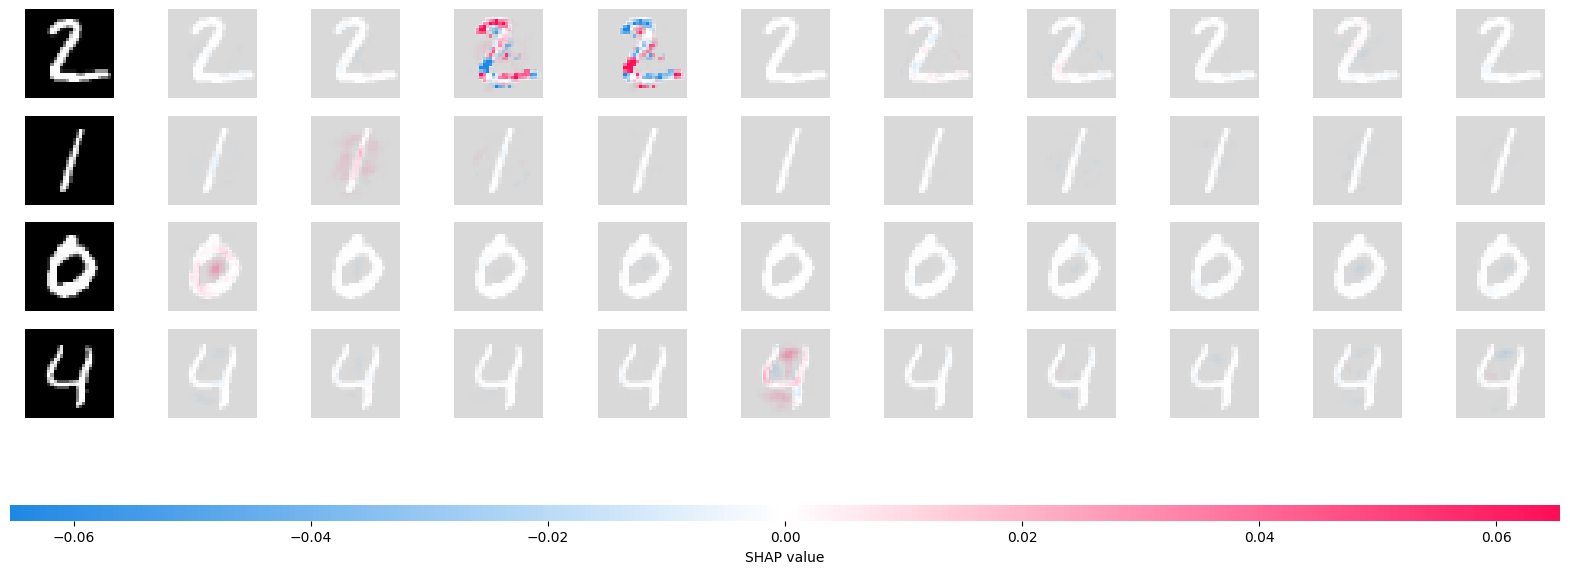

In [ ]:
# plot the feature attributions
shap.image_plot(shap_values, X_test[1:5])